# VCs Characteristics exploration

## Data ETL

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm  # For progress bar
from networkx.algorithms.community import greedy_modularity_communities

# warnings.filterwarnings('ignore')

import sys

sys.path.append('../') 

# Import custom modules
from libs.data_cleaning import *
from libs.data_extraction import *
from libs.network_analysis import *
from libs.nestedsness_calculator import *
from libs.curveball import *

plt.style.use('default')
sns.set_palette('husl')

country = "us"
data_dir = f'../../../data/{country}'

cleaned_data = load_clean_data(data_dir)

companies_clean = cleaned_data['companies']
investors_clean = cleaned_data['investors']
investments_clean = cleaned_data['investments']
funding_rounds_clean = cleaned_data['funding_rounds']

print(f"After cleaning:")
print(f"Companies: {len(companies_clean):,}")
print(f"Investors: {len(investors_clean):,}")
print(f"Investments: {len(investments_clean):,}")
print(f"Funding rounds: {len(funding_rounds_clean):,}")

After cleaning:
Companies: 22,527
Investors: 38,843
Investments: 147,832
Funding rounds: 268,283


In [3]:
vc_investments = extract_vc_investments(cleaned_data['investments'])
vc_investments['investor_name'] = vc_investments[['investor_name', 'investment_type']].agg('-'.join, axis=1)

Found 104618 VC investments
Unique companies with VC funding: 16932


In [ ]:
early_stages = set(['angel', 'pre_seed', 'seed', 'series_a'])
late_stages = set(['series_b', 'series_c', 'series_d', 'series_e', 'series_f', 'series_g', 'series_h', 'series_i'])

early_stage_mask = vc_investments['investment_type'].isin(early_stages)
late_stage_mask = vc_investments['investment_type'].isin(late_stages)

# Create left and right
right_investments = vc_investments[
  (early_stage_mask)
]

left_investments = vc_investments[
  (late_stage_mask)
]

investments_pairs = create_investment_pairs(left_investments, right_investments, 'left', 'right')
investments_pairs['announced_year'] = investments_pairs[['announced_year_left', 'announced_year_right']].max(axis=1)
investments_pairs['year'] = investments_pairs['announced_year']
investments_pairs['total_funding_usd'] = investments_pairs['total_funding_usd_left']
investments_pairs['company_country'] = investments_pairs['company_country_left']
investments_pairs['category'] = investments_pairs['category_left']

0.005
0.3
Created 169679 investment pairs
Covering 3666 unique investors


## Bipartite Network Analysis

### Create bipartite graph

In [ ]:
bipartite_graph = create_bipartite_graph(investments_pairs, 'investor_name_left', 'investor_name_right', None, 'left', 'right')
bipartite_sets = get_bipartite_sets(bipartite_graph)

set_0 = bipartite_sets['set_0']
set_1 = bipartite_sets['set_1']

### Identify communities

In [ ]:
G = bipartite_graph.copy()
max_communities = 10

cummunities = list(greedy_modularity_communities(G)) # @todo cutoff=10

color_map = {}
for c_idx, community in enumerate(cummunities):
    comm_size = len(community)
    for node in community:
        color_map[node] = c_idx

colors = [color_map[node] for node in G.nodes]

In [ ]:
plt.figure(figsize=(12, 10))

pos = nx.kamada_kawai_layout(G)

# Get unique community colors
unique_communities = sorted(set(colors))
color_map = plt.cm.Set1  # Use a color palette with distinct colors

# Draw the graph with improved visibility
nx.draw(G, pos, 
  node_color=colors, 
  node_size=20,  # Increased for better visibility
  width=0.2,     # Slightly thicker edges
  cmap=color_map,
  with_labels=False,
  alpha=0.8)

# Create a legend mapping colors to communities
legend_elements = []
for i, comm_idx in enumerate(unique_communities[:10]):  # Limit to top 10 for readability
    comm_size = colors.count(comm_idx)
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
        label=f'Community {comm_idx} ({comm_size} nodes)',
        markerfacecolor=color_map(comm_idx), 
        markersize=10))

plt.legend(handles=legend_elements, loc='upper right', title='Investor Communities')
plt.title("Clusters of investors detected via communities", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

# Print information about the largest communities
community_sizes = {}
for comm_idx in unique_communities:
    community_sizes[comm_idx] = colors.count(comm_idx)

top_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 investor communities by size:")
for comm_idx, size in top_communities:
    print(f"Community {comm_idx}: {size} investors")

KeyboardInterrupt: 

<Figure size 1200x1000 with 0 Axes>

### Analyse communities

#### Nestdness

In [14]:
# Initialize storage for community nestedness results
community_nestedness_results = []

# Parameters for null model analysis
n_iterations = 100  # Number of null models to generate
n_iterations_cv = 10000  # Number of curveball iterations
min_community_size = 100  # Minimum nodes required for analysis

print(f"Analyzing nestedness for {len(cummunities)} communities...")
print("=" * 60)

for comm_idx, community in enumerate(cummunities):
    if len(community) < min_community_size:
        print(f"Community {comm_idx}: Skipping (only {len(community)} nodes)")
        continue
    
    try:
        # Extract subgraph for this community
        subgraph = bipartite_graph.subgraph(community)
        
        # Get bipartite sets for this community
        community_set_0 = [node for node in community if node in set_0]
        community_set_1 = [node for node in community if node in set_1]
        
        # Skip if either set is empty
        if len(community_set_0) == 0 or len(community_set_1) == 0:
            print(f"Community {comm_idx}: Skipping (empty bipartite set)")
            continue
        
        print(f"Community {comm_idx}: {len(community_set_0)} left nodes, {len(community_set_1)} right nodes")
        
        # Create adjacency matrix for this community
        left_indices = {node: i for i, node in enumerate(community_set_0)}
        right_indices = {node: j for j, node in enumerate(community_set_1)}
        
        # Initialize adjacency matrix
        community_adjacency_matrix = np.zeros((len(community_set_0), len(community_set_1)))
        
        # Fill matrix with connections within this community
        for left_node in community_set_0:
            for right_node in community_set_1:
                if subgraph.has_edge(left_node, right_node):
                    left_idx = left_indices[left_node]
                    right_idx = right_indices[right_node]
                    community_adjacency_matrix[left_idx, right_idx] = 1
        
        # Calculate observed nestedness
        calculator = NestednessCalculator(community_adjacency_matrix)
        nestedness_score = calculator.nodf(community_adjacency_matrix)
        
        # Calculate basic network metrics
        num_edges = int(community_adjacency_matrix.sum())
        density = community_adjacency_matrix.mean()
        
        print(f"  Observed nestedness (NODF): {nestedness_score:.4f}")
        print(f"  Edges: {num_edges}, Density: {density:.4f}")
        
        # Generate null models if there are enough edges
        if num_edges < 5:
            print(f"  Skipping null model analysis (too few edges: {num_edges})")
            community_nestedness_results.append({
                'community_id': comm_idx,
                'community_size': len(community),
                'left_nodes': len(community_set_0),
                'right_nodes': len(community_set_1),
                'num_edges': num_edges,
                'density': density,
                'observed_nestedness': nestedness_score,
                'null_mean': np.nan,
                'null_std': np.nan,
                'z_score': np.nan,
                'p_value': np.nan,
                'significance': 'insufficient_data'
            })
            continue
        
        # Generate null models using curveball algorithm
        null_nestedness_scores = []
        
        print(f"  Generating {n_iterations} null models...")
        for i in tqdm(range(n_iterations), desc=f"Community {comm_idx}"):
            try:
                # Generate null model matrix by swapping while preserving degrees
                M = community_adjacency_matrix.copy()
                r_hp = find_presences(M)
                RM = curve_ball(M, r_hp, n_iterations_cv)
                
                null_matrix = RM.astype(community_adjacency_matrix.dtype)
                
                # Calculate nestedness of the null model
                calculator_null = NestednessCalculator(null_matrix)
                null_score = calculator_null.nodf(null_matrix)
                null_nestedness_scores.append(null_score)
                
            except Exception as e:
                print(f"    Error in null model iteration {i}: {e}")
                continue
        
        # Calculate statistical significance
        if len(null_nestedness_scores) > 0:
            null_nestedness_scores_np = np.array(null_nestedness_scores)
            mean_null = np.mean(null_nestedness_scores_np)
            std_null = np.std(null_nestedness_scores_np)
            
            if std_null > 0:
                z_score = (nestedness_score - mean_null) / std_null
            else:
                z_score = np.nan
            
            p_value = np.sum(null_nestedness_scores_np >= nestedness_score) / len(null_nestedness_scores_np)
            significance = 'significant' if p_value < 0.05 else 'not_significant'
            
            print(f"  Null model mean: {mean_null:.4f} ± {std_null:.4f}")
            print(f"  Z-score: {z_score:.4f}, P-value: {p_value:.4f} ({significance})")
        else:
            mean_null = std_null = z_score = p_value = np.nan
            significance = 'null_model_failed'
            print(f"  Warning: No valid null models generated")
        
        # Store results
        community_nestedness_results.append({
            'community_id': comm_idx,
            'community_size': len(community),
            'left_nodes': len(community_set_0),
            'right_nodes': len(community_set_1),
            'num_edges': num_edges,
            'density': density,
            'observed_nestedness': nestedness_score,
            'null_mean': mean_null,
            'null_std': std_null,
            'z_score': z_score,
            'p_value': p_value,
            'significance': significance,
            'null_scores': null_nestedness_scores if len(null_nestedness_scores) > 0 else []
        })
        
    except Exception as e:
        print(f"Community {comm_idx}: Error - {str(e)}")
        continue

print(f"\nAnalyzed {len(community_nestedness_results)} communities successfully")

Analyzing nestedness for 176 communities...
Community 0: 2745 left nodes, 1554 right nodes
  Observed nestedness (NODF): 0.0106
  Edges: 17223, Density: 0.0040
  Generating 100 null models...


Community 0: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


  Null model mean: 0.0120 ± 0.0001
  Z-score: -17.4871, P-value: 1.0000 (not_significant)
Community 1: 2196 left nodes, 1857 right nodes
  Observed nestedness (NODF): 0.0290
  Edges: 29568, Density: 0.0073
  Generating 100 null models...


Community 1: 100%|██████████| 100/100 [00:35<00:00,  2.78it/s]


  Null model mean: 0.0304 ± 0.0003
  Z-score: -4.8687, P-value: 1.0000 (not_significant)
Community 2: 2771 left nodes, 1097 right nodes
  Observed nestedness (NODF): 0.0908
  Edges: 48062, Density: 0.0158
  Generating 100 null models...


Community 2: 100%|██████████| 100/100 [00:50<00:00,  1.99it/s]


  Null model mean: 0.0876 ± 0.0007
  Z-score: 4.3712, P-value: 0.0000 (significant)
Community 3: 248 left nodes, 158 right nodes
  Observed nestedness (NODF): 0.0243
  Edges: 707, Density: 0.0180
  Generating 100 null models...


Community 3: 100%|██████████| 100/100 [00:04<00:00, 22.20it/s]


  Null model mean: 0.0380 ± 0.0009
  Z-score: -14.5324, P-value: 1.0000 (not_significant)
Community 4: 264 left nodes, 109 right nodes
  Observed nestedness (NODF): 0.0551
  Edges: 719, Density: 0.0250
  Generating 100 null models...


Community 4: 100%|██████████| 100/100 [00:05<00:00, 18.24it/s]


  Null model mean: 0.0686 ± 0.0021
  Z-score: -6.4592, P-value: 1.0000 (not_significant)
Community 5: 208 left nodes, 143 right nodes
  Observed nestedness (NODF): 0.0339
  Edges: 935, Density: 0.0314
  Generating 100 null models...


Community 5: 100%|██████████| 100/100 [00:05<00:00, 18.14it/s]


  Null model mean: 0.0542 ± 0.0009
  Z-score: -22.5466, P-value: 1.0000 (not_significant)
Community 6: 207 left nodes, 127 right nodes
  Observed nestedness (NODF): 0.0459
  Edges: 785, Density: 0.0299
  Generating 100 null models...


Community 6: 100%|██████████| 100/100 [00:05<00:00, 19.05it/s]


  Null model mean: 0.0720 ± 0.0019
  Z-score: -14.0804, P-value: 1.0000 (not_significant)
Community 7: 147 left nodes, 93 right nodes
  Observed nestedness (NODF): 0.0364
  Edges: 457, Density: 0.0334
  Generating 100 null models...


Community 7: 100%|██████████| 100/100 [00:04<00:00, 22.12it/s]


  Null model mean: 0.0550 ± 0.0014
  Z-score: -13.1528, P-value: 1.0000 (not_significant)
Community 8: 114 left nodes, 89 right nodes
  Observed nestedness (NODF): 0.0493
  Edges: 450, Density: 0.0444
  Generating 100 null models...


Community 8: 100%|██████████| 100/100 [00:04<00:00, 22.45it/s]


  Null model mean: 0.0915 ± 0.0030
  Z-score: -14.1504, P-value: 1.0000 (not_significant)
Community 9: 94 left nodes, 33 right nodes
  Observed nestedness (NODF): 0.0913
  Edges: 238, Density: 0.0767
  Generating 100 null models...


Community 9: 100%|██████████| 100/100 [00:05<00:00, 18.29it/s]


  Null model mean: 0.1570 ± 0.0043
  Z-score: -15.1661, P-value: 1.0000 (not_significant)
Community 10: 73 left nodes, 50 right nodes
  Observed nestedness (NODF): 0.0676
  Edges: 200, Density: 0.0548
  Generating 100 null models...


Community 10: 100%|██████████| 100/100 [00:03<00:00, 25.49it/s]


  Null model mean: 0.1050 ± 0.0037
  Z-score: -10.1404, P-value: 1.0000 (not_significant)
Community 11: 72 left nodes, 43 right nodes
  Observed nestedness (NODF): 0.0784
  Edges: 210, Density: 0.0678
  Generating 100 null models...


Community 11: 100%|██████████| 100/100 [00:04<00:00, 22.90it/s]


  Null model mean: 0.1377 ± 0.0049
  Z-score: -11.9999, P-value: 1.0000 (not_significant)
Community 12: 78 left nodes, 26 right nodes
  Observed nestedness (NODF): 0.0584
  Edges: 157, Density: 0.0774
  Generating 100 null models...


Community 12: 100%|██████████| 100/100 [00:04<00:00, 20.06it/s]

  Null model mean: 0.1101 ± 0.0037
  Z-score: -14.1298, P-value: 1.0000 (not_significant)
Community 13: Skipping (only 67 nodes)
Community 14: Skipping (only 59 nodes)
Community 15: Skipping (only 36 nodes)
Community 16: Skipping (only 36 nodes)
Community 17: Skipping (only 30 nodes)
Community 18: Skipping (only 29 nodes)
Community 19: Skipping (only 21 nodes)
Community 20: Skipping (only 19 nodes)
Community 21: Skipping (only 18 nodes)
Community 22: Skipping (only 17 nodes)
Community 23: Skipping (only 15 nodes)
Community 24: Skipping (only 15 nodes)
Community 25: Skipping (only 15 nodes)
Community 26: Skipping (only 14 nodes)
Community 27: Skipping (only 13 nodes)
Community 28: Skipping (only 13 nodes)
Community 29: Skipping (only 12 nodes)
Community 30: Skipping (only 12 nodes)
Community 31: Skipping (only 12 nodes)
Community 32: Skipping (only 11 nodes)
Community 33: Skipping (only 11 nodes)
Community 34: Skipping (only 11 nodes)
Community 35: Skipping (only 11 nodes)
Community 36:

In [15]:
# Convert results to DataFrame for analysis
community_nestedness_df = pd.DataFrame(community_nestedness_results)

if len(community_nestedness_df) > 0:
    print("Community Nestedness Analysis Summary:")
    print("=" * 50)
    print(f"Total communities analyzed: {len(community_nestedness_df)}")
    print(f"Significant communities (p < 0.05): {len(community_nestedness_df[community_nestedness_df['significance'] == 'significant'])}")
    
    # Display summary statistics
    print("\nNestedness Statistics:")
    valid_results = community_nestedness_df[community_nestedness_df['significance'].isin(['significant', 'not_significant'])]
    if len(valid_results) > 0:
        print(f"Mean observed nestedness: {valid_results['observed_nestedness'].mean():.4f} ± {valid_results['observed_nestedness'].std():.4f}")
        print(f"Mean null nestedness: {valid_results['null_mean'].mean():.4f} ± {valid_results['null_mean'].std():.4f}")
        print(f"Mean Z-score: {valid_results['z_score'].mean():.4f} ± {valid_results['z_score'].std():.4f}")
    
    # Display top communities by nestedness
    print("\nTop 10 Communities by Nestedness:")
    top_communities = community_nestedness_df.nlargest(10, 'observed_nestedness')
    for _, row in top_communities.iterrows():
        print(f"Community {row['community_id']}: NODF={row['observed_nestedness']:.4f}, "
              f"Size={row['community_size']}, Edges={row['num_edges']}, "
              f"P-value={row['p_value']:.4f} ({row['significance']})")
else:
    print("No communities were successfully analyzed")

Community Nestedness Analysis Summary:
Total communities analyzed: 13
Significant communities (p < 0.05): 1

Nestedness Statistics:
Mean observed nestedness: 0.0516 ± 0.0253
Mean null nestedness: 0.0784 ± 0.0421
Mean Z-score: -11.8725 ± 6.6170

Top 10 Communities by Nestedness:
Community 9: NODF=0.0913, Size=127, Edges=238, P-value=1.0000 (not_significant)
Community 2: NODF=0.0908, Size=3868, Edges=48062, P-value=0.0000 (significant)
Community 11: NODF=0.0784, Size=115, Edges=210, P-value=1.0000 (not_significant)
Community 10: NODF=0.0676, Size=123, Edges=200, P-value=1.0000 (not_significant)
Community 12: NODF=0.0584, Size=104, Edges=157, P-value=1.0000 (not_significant)
Community 4: NODF=0.0551, Size=373, Edges=719, P-value=1.0000 (not_significant)
Community 8: NODF=0.0493, Size=203, Edges=450, P-value=1.0000 (not_significant)
Community 6: NODF=0.0459, Size=334, Edges=785, P-value=1.0000 (not_significant)
Community 7: NODF=0.0364, Size=240, Edges=457, P-value=1.0000 (not_significant)

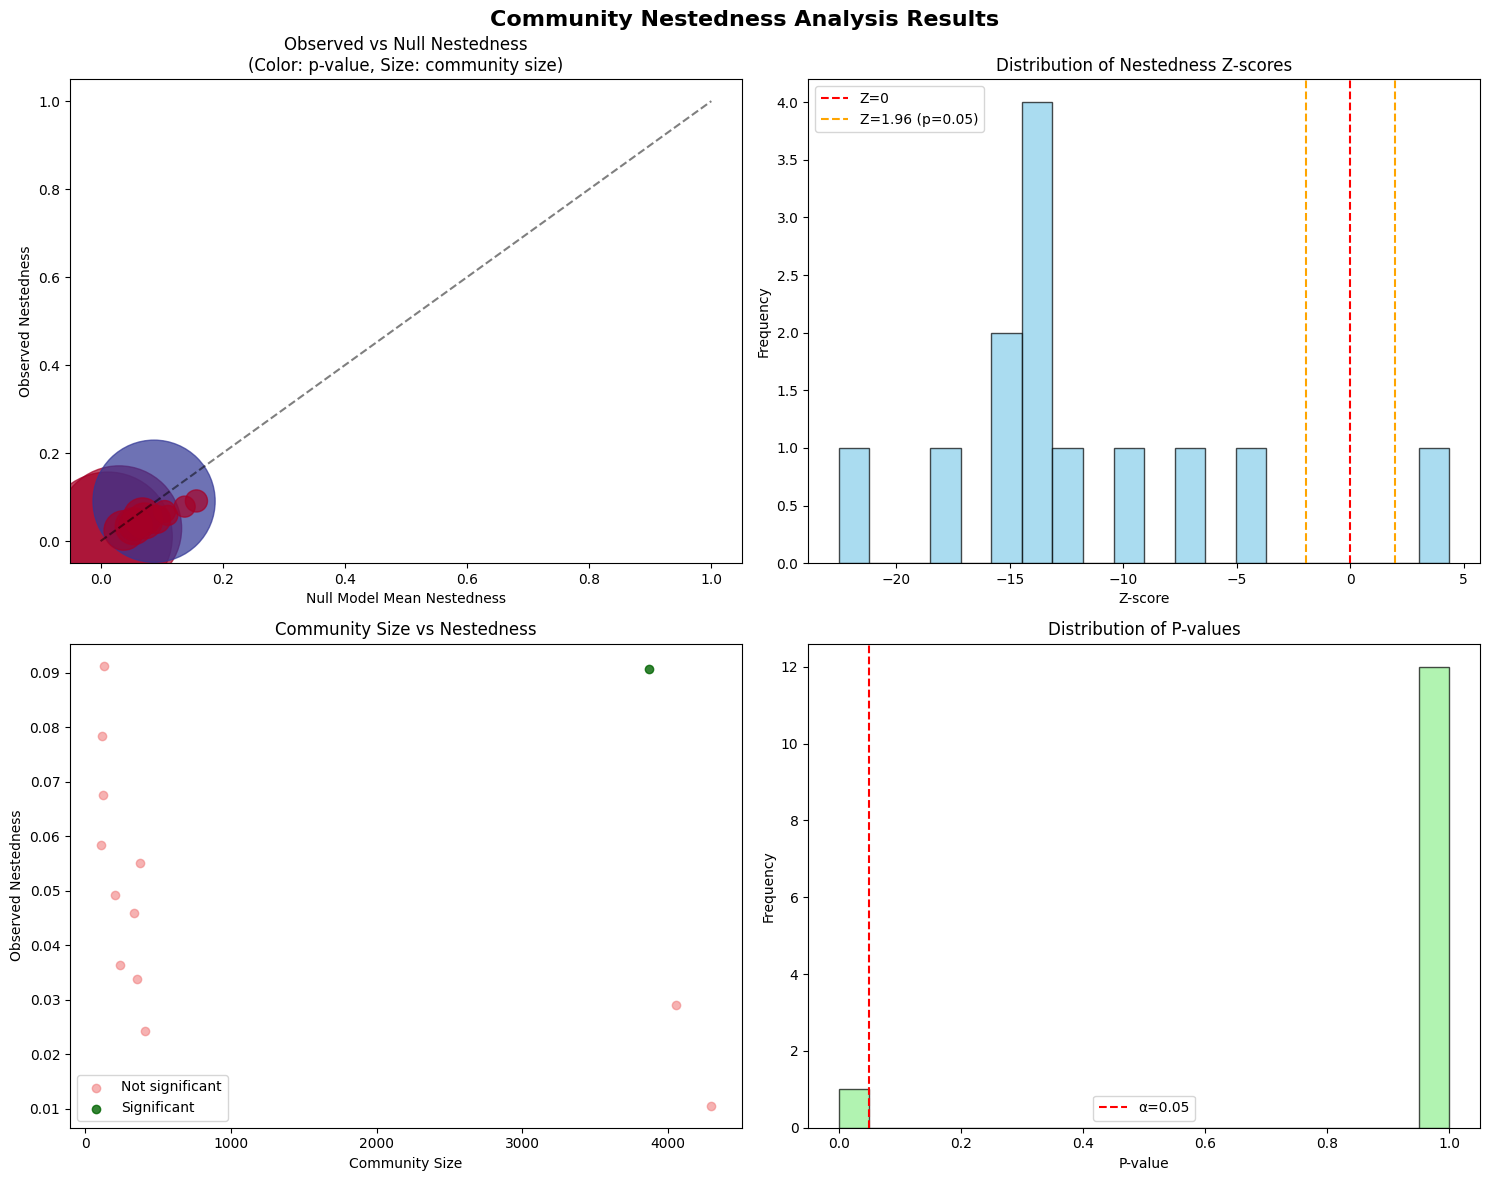


Detailed analysis for top 1 significant communities:


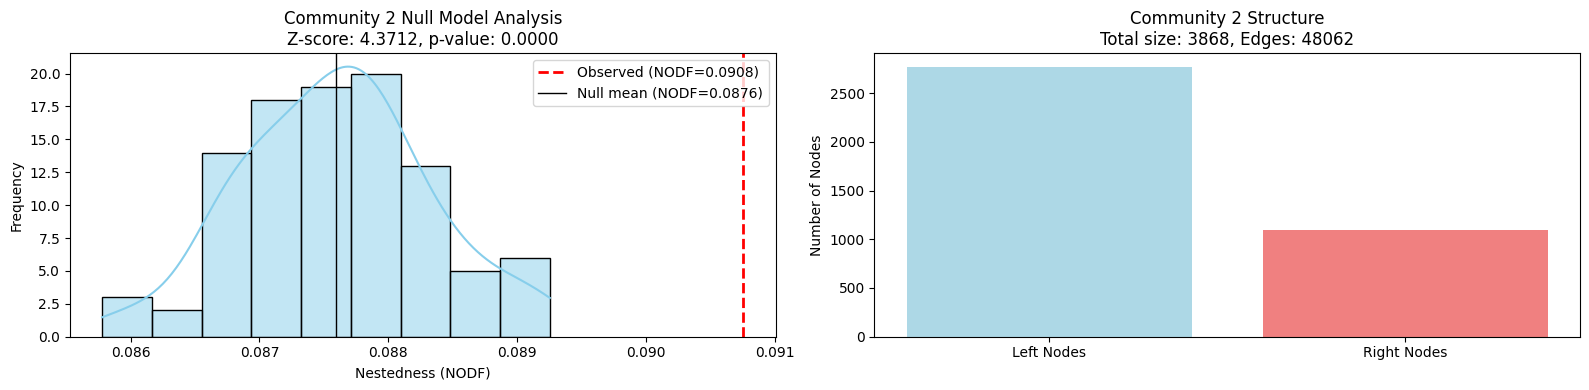

In [16]:
# Visualize community nestedness results
if len(community_nestedness_df) > 0:
    valid_results = community_nestedness_df[community_nestedness_df['significance'].isin(['significant', 'not_significant'])]
    
    if len(valid_results) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Community Nestedness Analysis Results', fontsize=16, fontweight='bold')
        
        # Plot 1: Observed vs Null Nestedness
        axes[0, 0].scatter(valid_results['null_mean'], valid_results['observed_nestedness'], 
                          c=valid_results['p_value'], s=valid_results['community_size']*2, 
                          cmap='RdYlBu_r', alpha=0.7)
        axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)  # Diagonal line
        axes[0, 0].set_xlabel('Null Model Mean Nestedness')
        axes[0, 0].set_ylabel('Observed Nestedness')
        axes[0, 0].set_title('Observed vs Null Nestedness\n(Color: p-value, Size: community size)')
        
        # Plot 2: Distribution of Z-scores
        axes[0, 1].hist(valid_results['z_score'].dropna(), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0, 1].axvline(0, color='red', linestyle='--', label='Z=0')
        axes[0, 1].axvline(1.96, color='orange', linestyle='--', label='Z=1.96 (p=0.05)')
        axes[0, 1].axvline(-1.96, color='orange', linestyle='--')
        axes[0, 1].set_xlabel('Z-score')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].set_title('Distribution of Nestedness Z-scores')
        axes[0, 1].legend()
        
        # Plot 3: Community size vs Nestedness
        significant_mask = valid_results['significance'] == 'significant'
        axes[1, 0].scatter(valid_results[~significant_mask]['community_size'], 
                          valid_results[~significant_mask]['observed_nestedness'],
                          c='lightcoral', alpha=0.6, label='Not significant')
        axes[1, 0].scatter(valid_results[significant_mask]['community_size'], 
                          valid_results[significant_mask]['observed_nestedness'],
                          c='darkgreen', alpha=0.8, label='Significant')
        axes[1, 0].set_xlabel('Community Size')
        axes[1, 0].set_ylabel('Observed Nestedness')
        axes[1, 0].set_title('Community Size vs Nestedness')
        axes[1, 0].legend()
        
        # Plot 4: P-value distribution
        axes[1, 1].hist(valid_results['p_value'].dropna(), bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
        axes[1, 1].axvline(0.05, color='red', linestyle='--', label='α=0.05')
        axes[1, 1].set_xlabel('P-value')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Distribution of P-values')
        axes[1, 1].legend()
        
        plt.tight_layout()
        plt.show()
        
        # Create detailed plots for significant communities
        significant_communities = valid_results[valid_results['significance'] == 'significant'].head(5)
        
        if len(significant_communities) > 0:
            print(f"\nDetailed analysis for top {len(significant_communities)} significant communities:")
            fig, axes = plt.subplots(len(significant_communities), 2, 
                                   figsize=(16, 4*len(significant_communities)))
            if len(significant_communities) == 1:
                axes = axes.reshape(1, -1)
            
            for i, (_, row) in enumerate(significant_communities.iterrows()):
                comm_idx = row['community_id']
                null_scores = row['null_scores']
                
                if len(null_scores) > 0:
                    # Histogram of null model distribution
                    sns.histplot(null_scores, kde=True, color='skyblue', ax=axes[i, 0])
                    axes[i, 0].axvline(row['observed_nestedness'], color='red', linestyle='--', 
                                      linewidth=2, label=f'Observed (NODF={row["observed_nestedness"]:.4f})')
                    axes[i, 0].axvline(row['null_mean'], color='black', linestyle='-', 
                                      linewidth=1, label=f'Null mean (NODF={row["null_mean"]:.4f})')
                    axes[i, 0].set_title(f'Community {comm_idx} Null Model Analysis\n'
                                         f'Z-score: {row["z_score"]:.4f}, p-value: {row["p_value"]:.4f}')
                    axes[i, 0].set_xlabel('Nestedness (NODF)')
                    axes[i, 0].set_ylabel('Frequency')
                    axes[i, 0].legend()
                
                # Bar plot of community structure
                axes[i, 1].bar(['Left Nodes', 'Right Nodes'], 
                              [row['left_nodes'], row['right_nodes']], 
                              color=['lightblue', 'lightcoral'])
                axes[i, 1].set_title(f'Community {comm_idx} Structure\n'
                                     f'Total size: {row["community_size"]}, Edges: {row["num_edges"]}')
                axes[i, 1].set_ylabel('Number of Nodes')
            
            plt.tight_layout()
            plt.show()
    else:
        print("No valid results available for visualization")
else:
    print("No data available for visualization")